In [6]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax, random, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, MCMC, NUTS

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 冠動脈疾患と喫煙習慣に関するデータ

一般化線形モデル入門に掲載のデータ。冠動脈疾患による死亡と、年齢及び喫煙習慣の関係を調べる。


※人年とは、観測期間✕人数の数値。

In [7]:
data = pd.DataFrame({
    
    'agecat':[1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'deaths':[ 32, 104, 206, 186, 102, 2, 12, 28, 28, 31],
    'population':[52407, 43248, 28612, 12663, 5317, 18790, 10673, 5710, 2585, 1462],
    'smoke':[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
})

agecat = data['agecat'].values
deaths = data['deaths'].values
smoke = data['smoke'].values

population = data['population'].values

agecat_mu = np.mean(agecat)
agecat_sd = np.std(agecat)

agecat_scaled = (agecat - agecat_mu) / agecat_sd

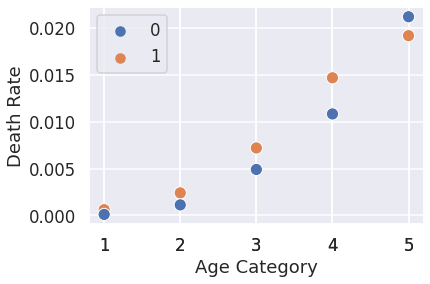

In [8]:
sns.scatterplot(x=agecat, y=deaths/population, hue=smoke, s=150)
plt.xticks(agecat)

plt.xlabel('Age Category')
plt.ylabel('Death Rate');

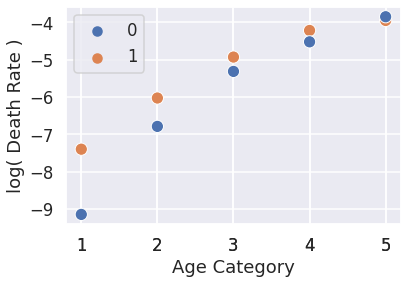

In [9]:
sns.scatterplot(x=agecat, y=np.log(deaths/population), hue=smoke, s=150)
plt.xticks(agecat)

plt.xlabel('Age Category')
plt.ylabel('log( Death Rate )');

In [11]:
def model(smoke=None, agecat_scaled=None, deaths=None, population=None, num_data=0):
    
    b1 = numpyro.sample('b1', dist.Normal(0, 10))
    b2 = numpyro.sample('b2', dist.Normal(0, 10))
    b3 = numpyro.sample('b3', dist.Normal(0, 10))
    
    theta = b1 + b2 * smoke + b3 * agecat_scaled
    
    mu = numpyro.deterministic("mu", jnp.exp(theta) * population)
        
    with numpyro.plate('data', num_data):    
        numpyro.sample('obs', dist.Poisson(rate=mu), obs=deaths)

nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), smoke=smoke, agecat_scaled=agecat_scaled, deaths=deaths, population=population, num_data=len(agecat_scaled))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 3500/3500 [00:00<00:00, 5158.18it/s, 7 steps of size 2.47e-01. acc. prob=0.94] 


In [12]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

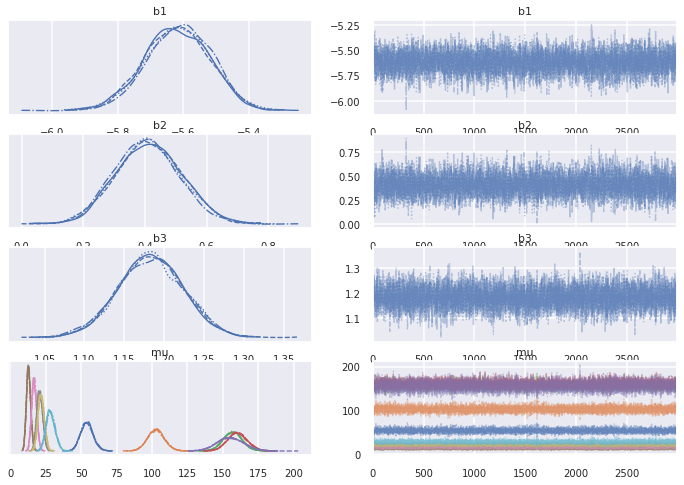

In [13]:
az.plot_trace(idata);

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,-5.617,0.099,-5.800,-5.434,0.001,0.001,4364.0,5227.0,1.0
b2,0.411,0.106,0.218,0.611,0.002,0.001,4433.0,5242.0,1.0
b3,1.183,0.041,1.107,1.260,0.001,0.000,5734.0,4979.0,1.0
mu[0],54.099,4.360,46.092,62.432,0.054,0.039,6554.0,6607.0,1.0
mu[1],102.882,5.902,91.281,113.506,0.067,0.048,7729.0,8747.0,1.0
mu[2],156.983,6.567,144.209,168.852,0.061,0.043,11605.0,9283.0,1.0
mu[3],160.373,6.920,147.400,173.241,0.066,0.047,10963.0,8581.0,1.0
mu[4],155.564,9.365,138.350,173.509,0.107,0.076,7591.0,7936.0,1.0
mu[5],12.912,1.521,10.116,15.777,0.023,0.016,4498.0,4895.0,1.0
mu[6],16.904,1.768,13.759,20.351,0.027,0.019,4366.0,4945.0,1.0


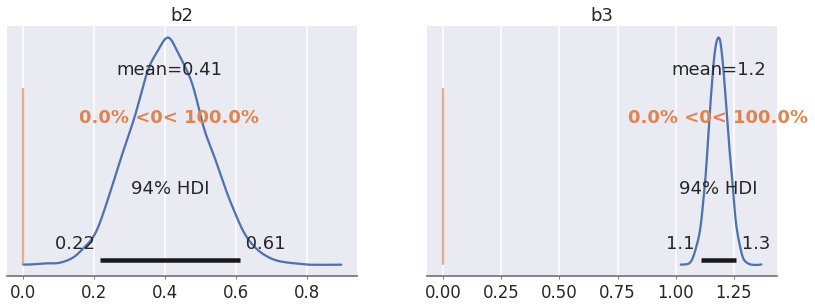

In [15]:
az.plot_posterior(idata, var_names=['b2', 'b3'], ref_val=0);

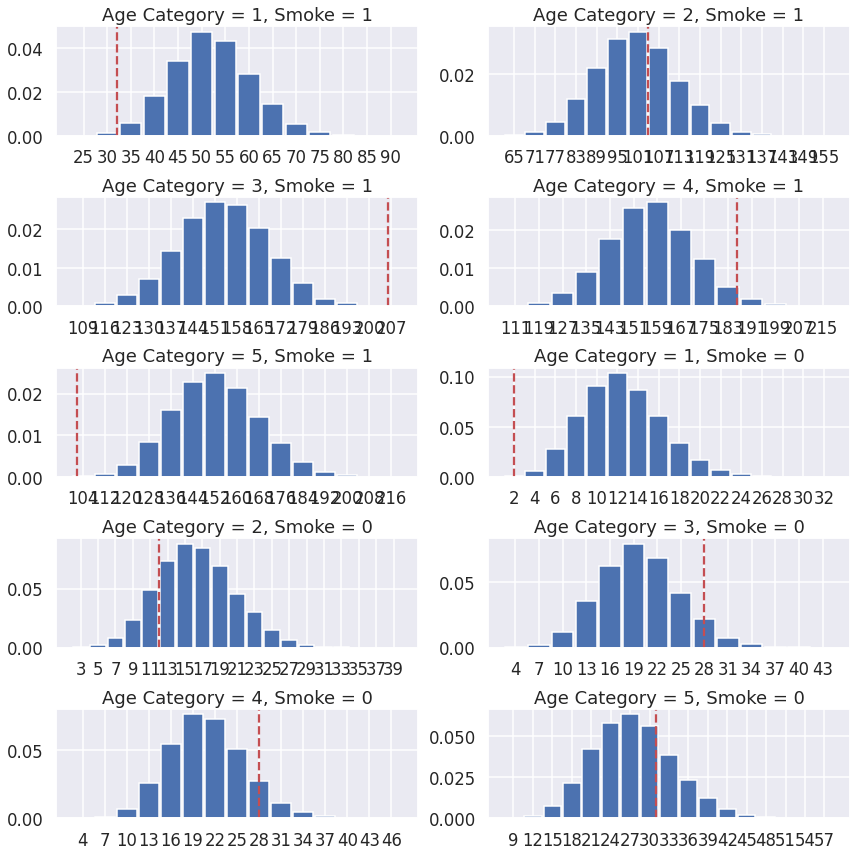

In [16]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), agecat_scaled=agecat_scaled, smoke=smoke, population=population, num_data=len(agecat_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

fig = plt.figure(figsize=(12, 12))

for k in range(10):
    
    ax = fig.add_subplot(5, 2, k+1)
    
    az.plot_dist(ppc_samples['obs'][:, k])
    ax.axvline(deaths[k], color='r', linestyle='dashed')
    ax.set_title('Age Category = {}, Smoke = {}'.format(agecat[k], smoke[k]))

plt.tight_layout()

実際のデータと結構外れた位置に実データが出てきてしまっているので何かがおかしい。今回は外れている部分が多いのでモデル側に問題がありそうだと推測される。

In [17]:
idata.to_netcdf('./result_data/smoke_model1.nc')

'./result_data/smoke_model1.nc'

# 交互作用を考えたモデル

In [19]:
agesq = agecat_scaled * agecat_scaled
smokage = smoke * agecat_scaled

In [20]:
def model(smoke=None, agecat_scaled=None, agesq=None, smokage=None, deaths=None, population=None, num_data=0):
    
    b1 = numpyro.sample('b1_intercept', dist.Normal(0, 10))
    b2 = numpyro.sample('b2_smoke', dist.Normal(0, 10))
    b3 = numpyro.sample('b3_agecat', dist.Normal(0, 10))
    b4 = numpyro.sample('b4_agesq', dist.Normal(0, 10))
    b5 = numpyro.sample('b5_smokage', dist.Normal(0, 10))
    
    theta = b1 + b2 * smoke + b3 * agecat_scaled + b4 * agesq + b5 * smokage
    
    mu = jax.numpy.exp(theta) * population
        
    with numpyro.plate('data', num_data):
        
        numpyro.sample('obs', dist.Poisson(rate=mu), obs=deaths)

nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), smoke=smoke, agecat_scaled=agecat_scaled, agesq=agesq,
         smokage=smokage, deaths=deaths, population=population, num_data=len(agecat_scaled))

mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 3500/3500 [00:00<00:00, 4656.45it/s, 15 steps of size 1.94e-01. acc. prob=0.91]


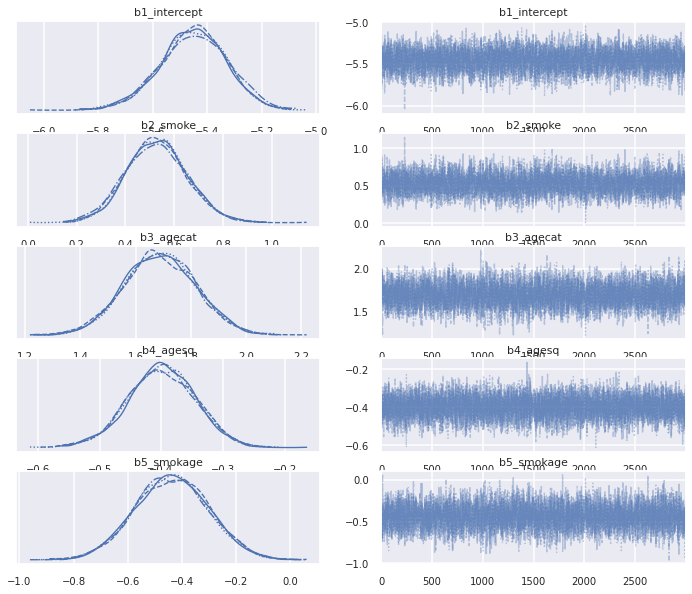

In [21]:
az.plot_trace(idata);

In [22]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1_intercept,-5.452,0.121,-5.675,-5.219,0.002,0.001,4187.0,5423.0,1.0
b2_smoke,0.528,0.124,0.302,0.768,0.002,0.001,4196.0,5487.0,1.0
b3_agecat,1.689,0.128,1.448,1.929,0.002,0.001,4415.0,5869.0,1.0
b4_agesq,-0.399,0.054,-0.501,-0.295,0.001,0.000,7356.0,7185.0,1.0
b5_smokage,-0.438,0.136,-0.685,-0.177,0.002,0.001,4374.0,5631.0,1.0


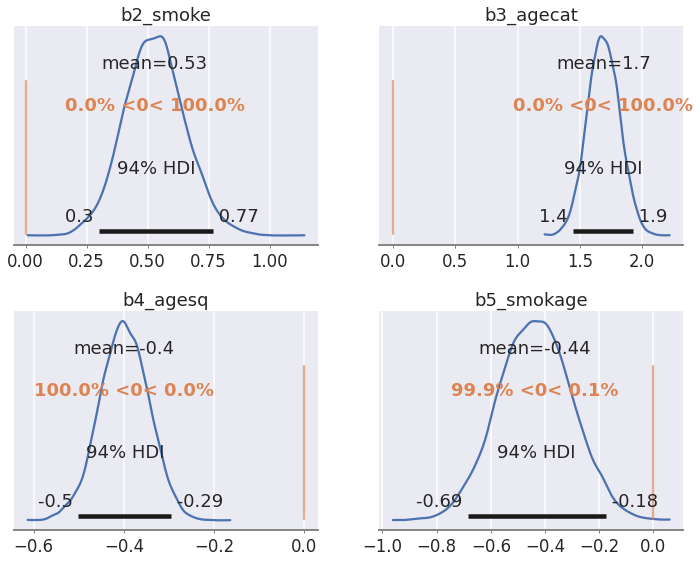

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

az.plot_posterior(idata, var_names=['b2_smoke', 'b3_agecat', 'b4_agesq', 'b5_smokage'], ref_val=0, ax=axes)

plt.subplots_adjust(top=1.0, hspace=0.3)

In [24]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), smoke=smoke, agecat_scaled=agecat_scaled, agesq=agesq,
                         smokage=smokage, population=population, num_data=len(agecat_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

ppc_samples['obs'].shape

(12000, 10)

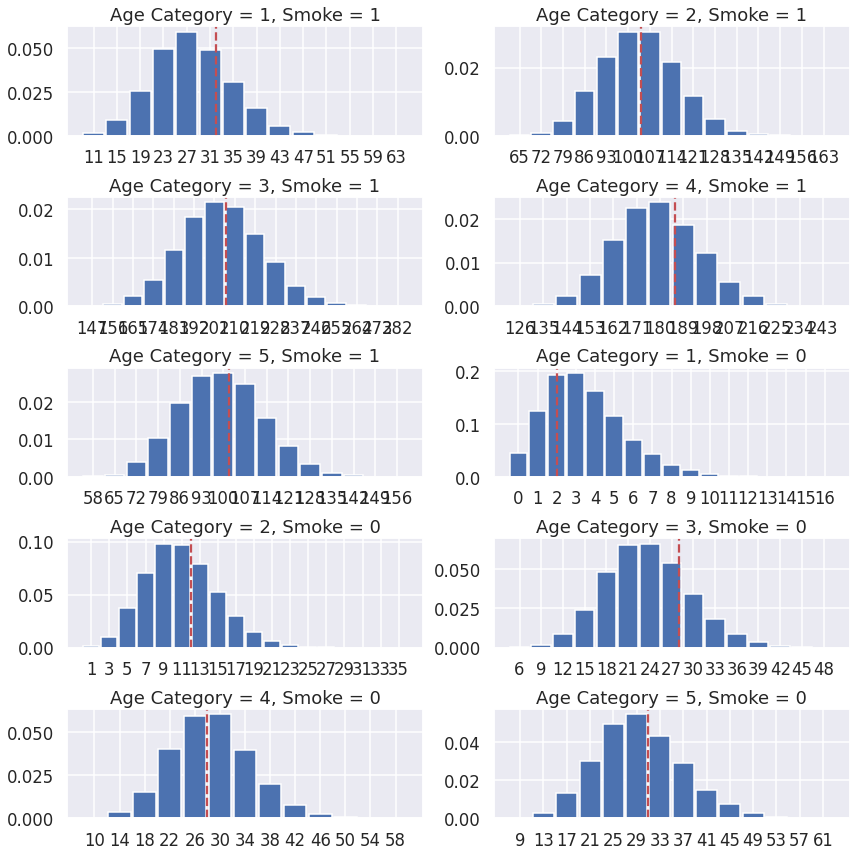

In [25]:
fig = plt.figure(figsize=(12, 12))

for k in range(10):
    
    ax = fig.add_subplot(5, 2, k+1)
    
    az.plot_dist(ppc_samples['obs'][:, k])
    ax.axvline(deaths[k], color='r', linestyle='dashed')
    ax.set_title('Age Category = {}, Smoke = {}'.format(agecat[k], smoke[k]))

plt.tight_layout()

In [27]:
idata_base = az.from_netcdf('./result_data/smoke_model1.nc')

In [28]:
dict_idata = {'Linear Terms Only':idata_base, 'Interaction and Non-linear Term Added':idata}
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
df_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Interaction and Non-linear Term Added,0,64.095331,1.940552,0.00000,1.000000e+00,4.019853,0.000000,False,deviance
Linear Terms Only,1,155.556611,22.325808,91.46128,2.913225e-13,34.926372,33.610722,True,deviance


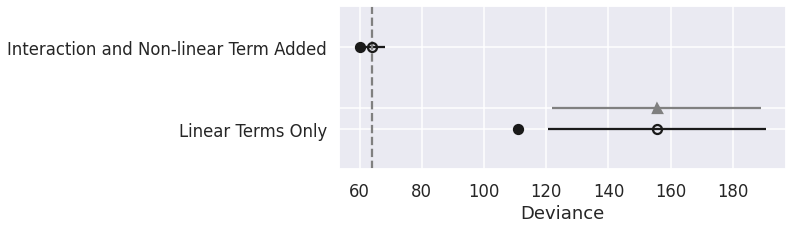

In [29]:
az.plot_compare(df_waic, figsize=(8, 3));

In [30]:
df_loo = az.compare(dict_idata, ic='loo', scale='deviance')
df_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Interaction and Non-linear Term Added,0,64.876120,2.330946,0.000000,1.0,4.079156,0.000000,True,deviance
Linear Terms Only,1,159.549013,24.322009,94.672894,0.0,36.744655,35.288775,True,deviance


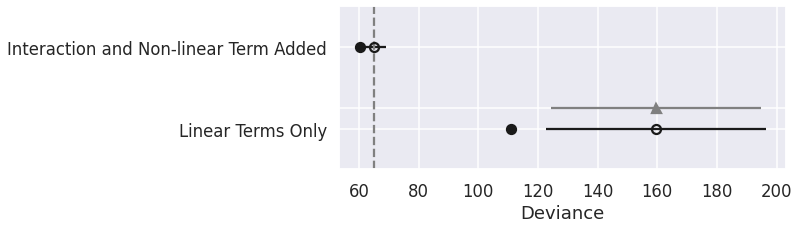

In [31]:
az.plot_compare(df_loo, figsize=(8, 3));